In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-lemm-csv/final_lemm.csv


# IMPORTS

In [2]:
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# SETUP

In [3]:
stop_words = stopwords.words("english")

df = pd.read_csv("/kaggle/input/final-lemm-csv/final_lemm.csv", index_col=0)
df["poem"] = df["poem"].str.replace("\n", " ").str.lower().str.translate(str.maketrans('', '', string.punctuation + "‘’")).replace("\d+",  "", regex=True)
df["poem"] = df["poem"].apply(lambda poem: " ".join([word for word in poem.split() if word not in stop_words]))
df = df[df["poem"].str.len() > 20].reset_index(drop=True)
df["poem"] = df["poem"].apply(lambda poem : ''.join([i if ord(i) < 128 else ' ' for i in poem])) # remove non ascii chars
df["poem"] = df["poem"].apply(lambda poem : ' '.join([w if len(w) != 1 else '' for w in poem.split()])) # remove single char words
df = df[['poem','topic']]

# XGBoost model

In [4]:
# Vectorizing poems
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 
X = tfidf_vectorizer.fit_transform(df['poem'])

# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['topic'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## GridSearchCV

In [5]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.1, 0.2],
    'max_depth':  [1, 2, 3],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0.7, 0.8, 0.9, 1.0, 1.5, 2, 2.5, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

In [6]:
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


In [7]:
best_params = grid_search.best_params_
# Print the best parameters found by GridSearchCV
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.7, 'subsample': 0.8, 'colsample_bytree': 0.8}


In [8]:
model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.7, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [9]:
new_poem = ["I love every single inch of you !"]

new_poem_transformed = tfidf_vectorizer.transform(new_poem)
predicted_label = model.predict(new_poem_transformed)

predicted_label_decoded = label_encoder.inverse_transform(predicted_label)
print("Predicted Label:", predicted_label_decoded[0])

Predicted Label: love


In [10]:
probabilities = model.predict_proba(new_poem_transformed)
labels = label_encoder.classes_

prob_dict = {label: prob for label, prob in zip(labels, probabilities[0])}

sorted_probabilities = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)

# Print probabilities for each label in descending order
for label, probability in sorted_probabilities:
    print(f"Probability of '{label}': {probability:.4f}")

Probability of 'love': 0.7328
Probability of 'nature': 0.0856
Probability of 'arts&sciences': 0.0804
Probability of 'relationships': 0.0581
Probability of 'religion': 0.0431


In [11]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4845617529880478


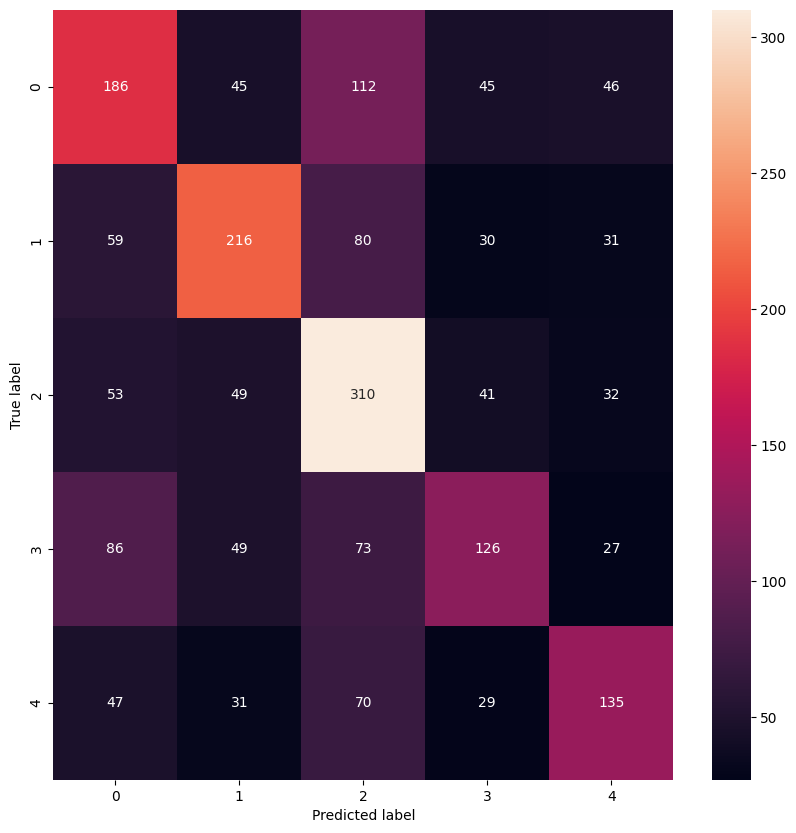

In [12]:
cm = metrics.confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [13]:
class_names = list(set(df['topic']))
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

               precision    recall  f1-score   support

relationships       0.43      0.43      0.43       434
       nature       0.55      0.52      0.54       416
         love       0.48      0.64      0.55       485
arts&sciences       0.46      0.35      0.40       361
     religion       0.50      0.43      0.46       312

     accuracy                           0.48      2008
    macro avg       0.49      0.47      0.48      2008
 weighted avg       0.49      0.48      0.48      2008

